## Notes

This is producing unsatisfactory results, but the method is valid and I will keep it as a reference.

### Imports

In [ ]:
import logging
import sys
import os
import pandas as pd

sys.path.append(os.path.abspath(".."))

from scripts import get_session, load_config, setup_logging
from orm_models import ACS2017CountyData, MortalityRate2014


### Config and Logging Setup

In [10]:
try:
    config = load_config()
    setup_logging(config['paths']['log_path'])
    logging.info("Starting the data analysis project.")
except Exception as e:
    logging.error(f"Failed to load config or setup logging: {e}")
    raise

INFO:root:Starting the data analysis project.
2025-02-22 20:13:19,892 - INFO - Starting the data analysis project.
2025-02-22 20:13:19,892 - INFO - Starting the data analysis project.


### Database Session

In [11]:
try:
    session = get_session()
    logging.info("Database session created successfully.")
except Exception as e:
    logging.error(f"Failed to create database session: {e}")
    raise

INFO:root:Database session created successfully.
2025-02-22 20:13:19,907 - INFO - Database session created successfully.
2025-02-22 20:13:19,907 - INFO - Database session created successfully.


### Query netflix Data

In [12]:
try:
    data = session.query(
        ACS2017CountyData.poverty,
        MortalityRate2014.mortality_rate_2014_max
        ).filter(ACS2017CountyData.fips_code == MortalityRate2014.fips_code)\
        .all()

    
    df = pd.DataFrame(data)
    print(df.head())
except Exception as e:
    logging.error(f"Failed to query show data: {e}")
    raise


   poverty  mortality_rate_2014_max
0     13.7                     5.21
1     11.8                     4.08
2     27.2                     6.24
3     15.2                     6.85
4     15.6                     4.06


### Visualize Data

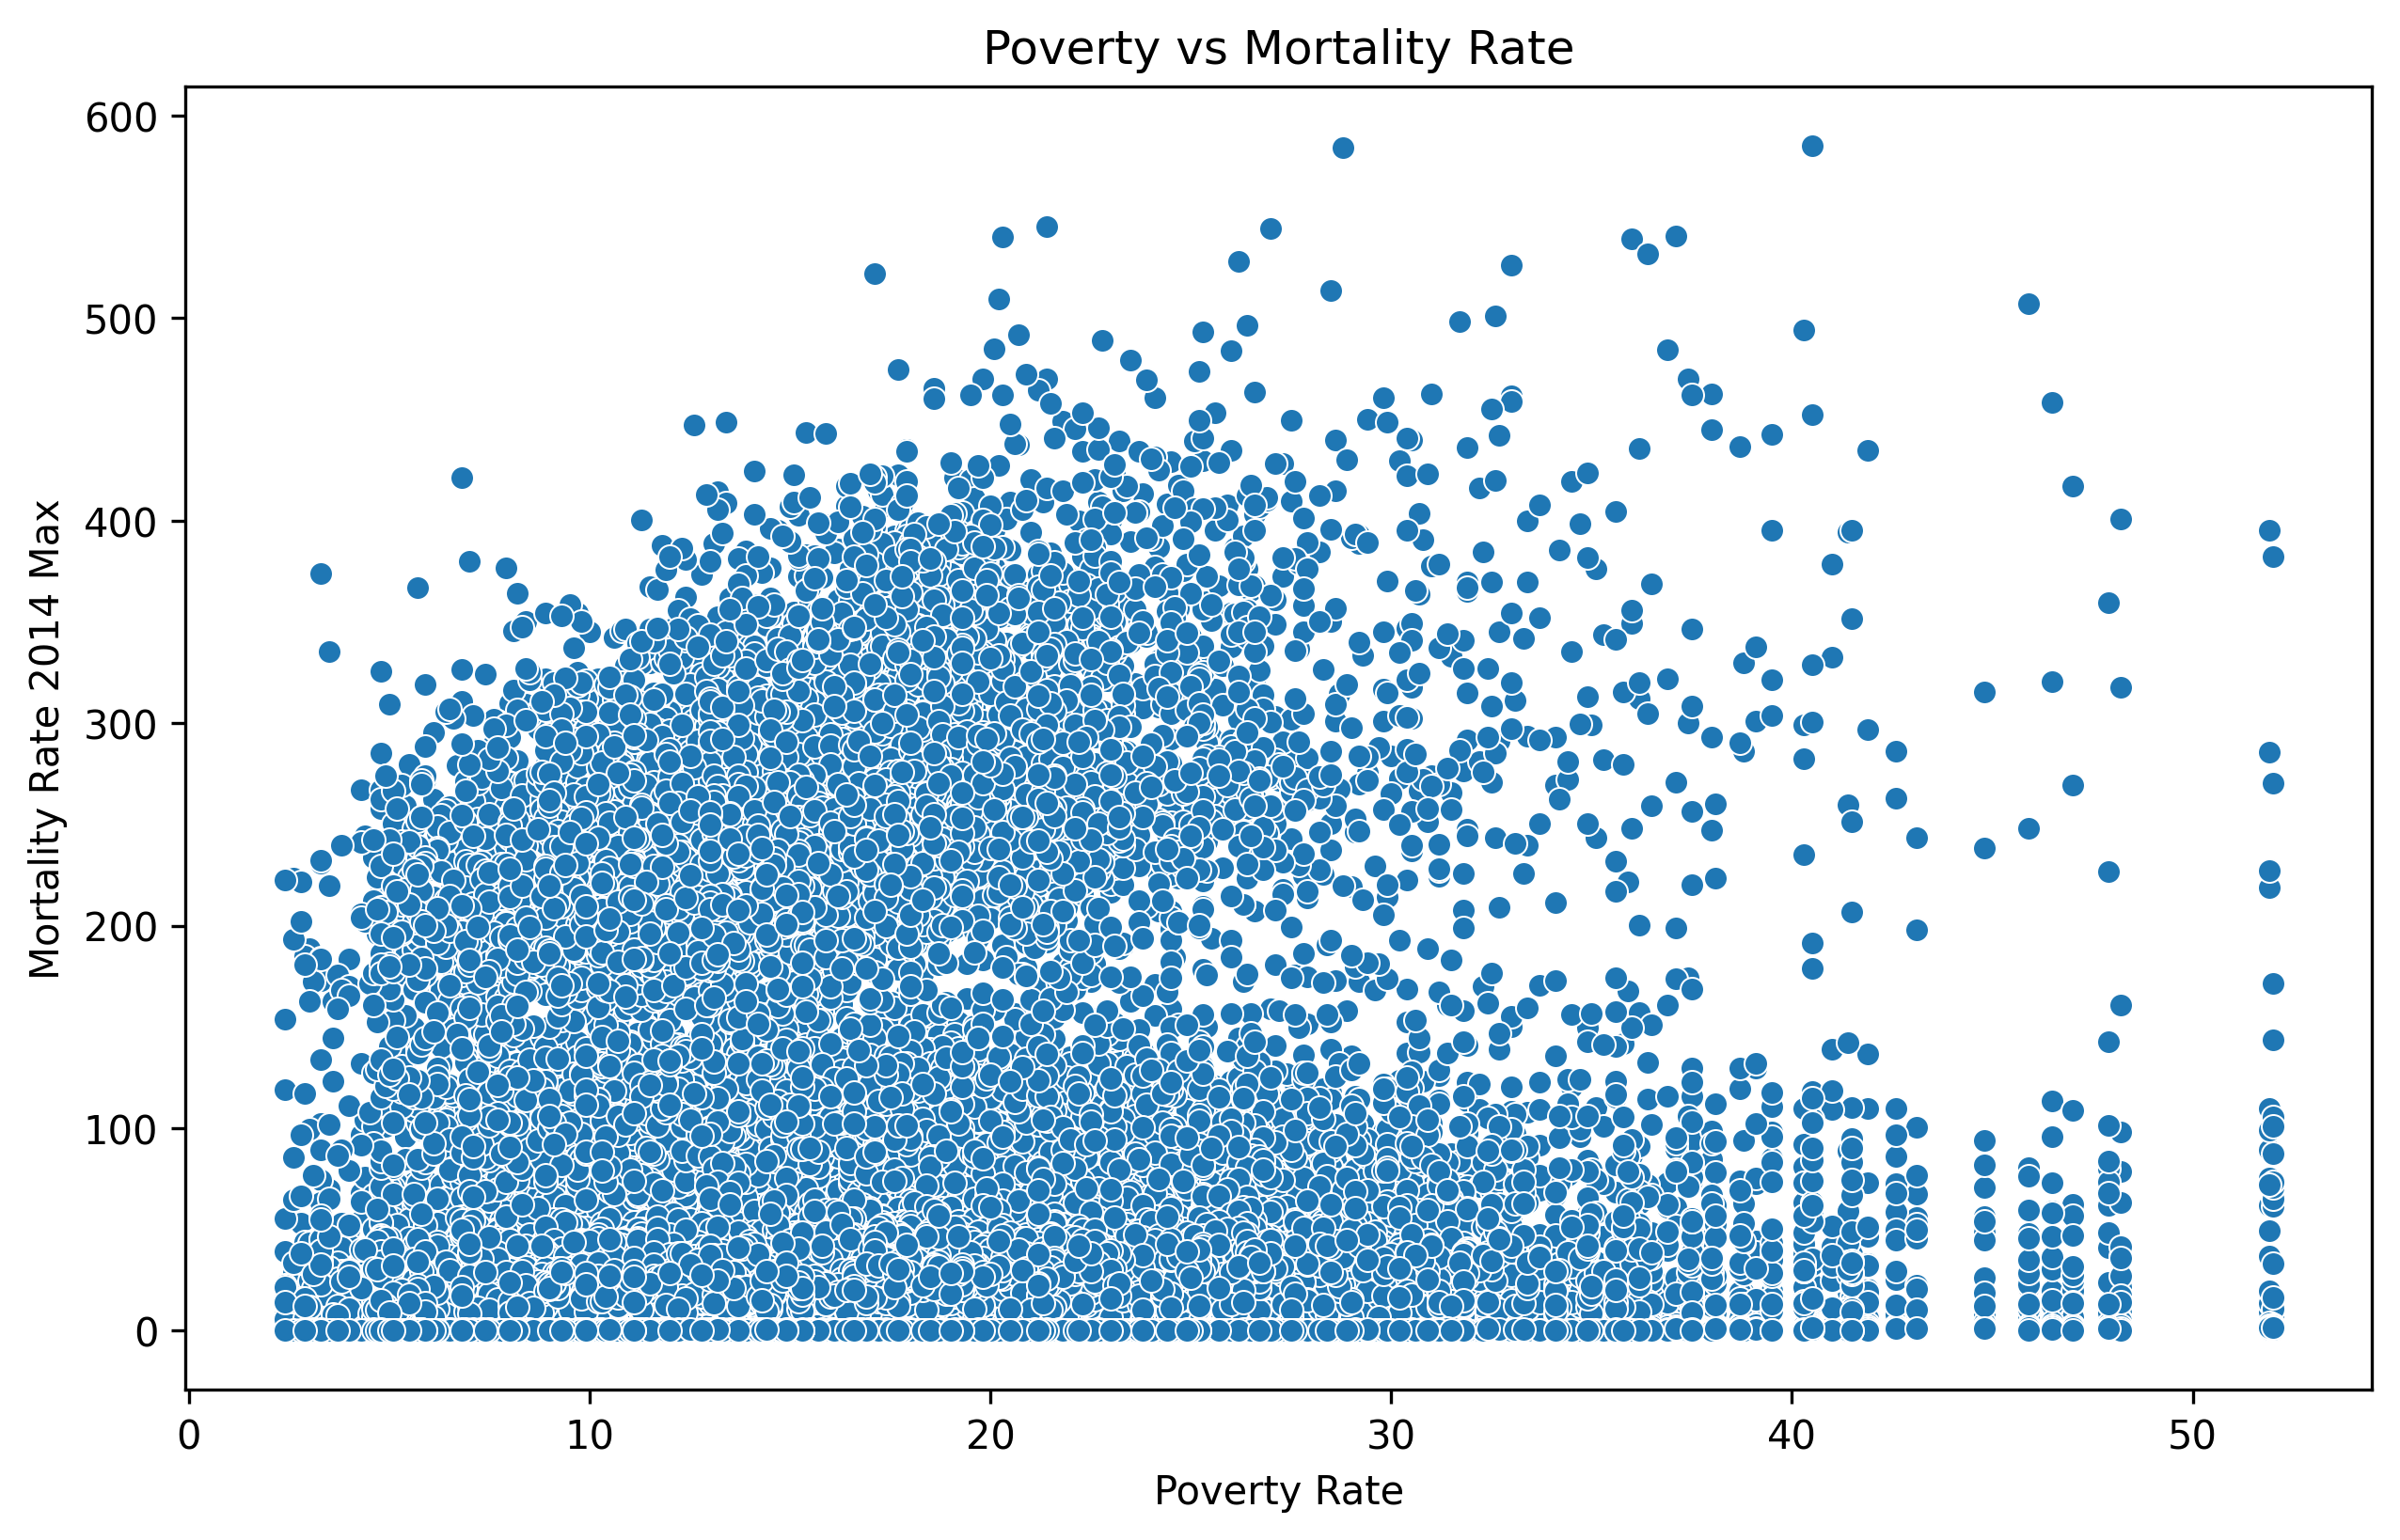

In [13]:
import seaborn as sns

import matplotlib.pyplot as plt

# Plotting poverty versus mortality rate
plt.figure(figsize=(10, 6), dpi=300)
sns.scatterplot(x='poverty', y='mortality_rate_2014_max', data=df)
plt.title('Poverty vs Mortality Rate')
plt.xlabel('Poverty Rate')
plt.ylabel('Mortality Rate 2014 Max')
plt.show()

### Preprocess Data

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df = df.dropna()

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)



### Apply DBSCAN

In [15]:
from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=0.1, min_samples=5)
clusters = dbscan.fit_predict(df_scaled)

### Analyze Cluster Labels

In [16]:
df['Cluster'] = clusters
print(df['Cluster'].value_counts())

Cluster
 0     64929
-1       600
 1       133
 3        34
 2        22
 5        18
 6        18
 20       16
 23       15
 32       14
 8         9
 4         9
 10        8
 19        8
 9         8
 14        7
 29        7
 22        7
 28        7
 18        7
 16        7
 17        6
 21        6
 24        6
 27        6
 11        6
 15        5
 26        5
 12        5
 33        5
 30        5
 31        5
 34        5
 7         5
 13        4
 25        4
Name: count, dtype: int64


### Visualize DBSCAN Clusters

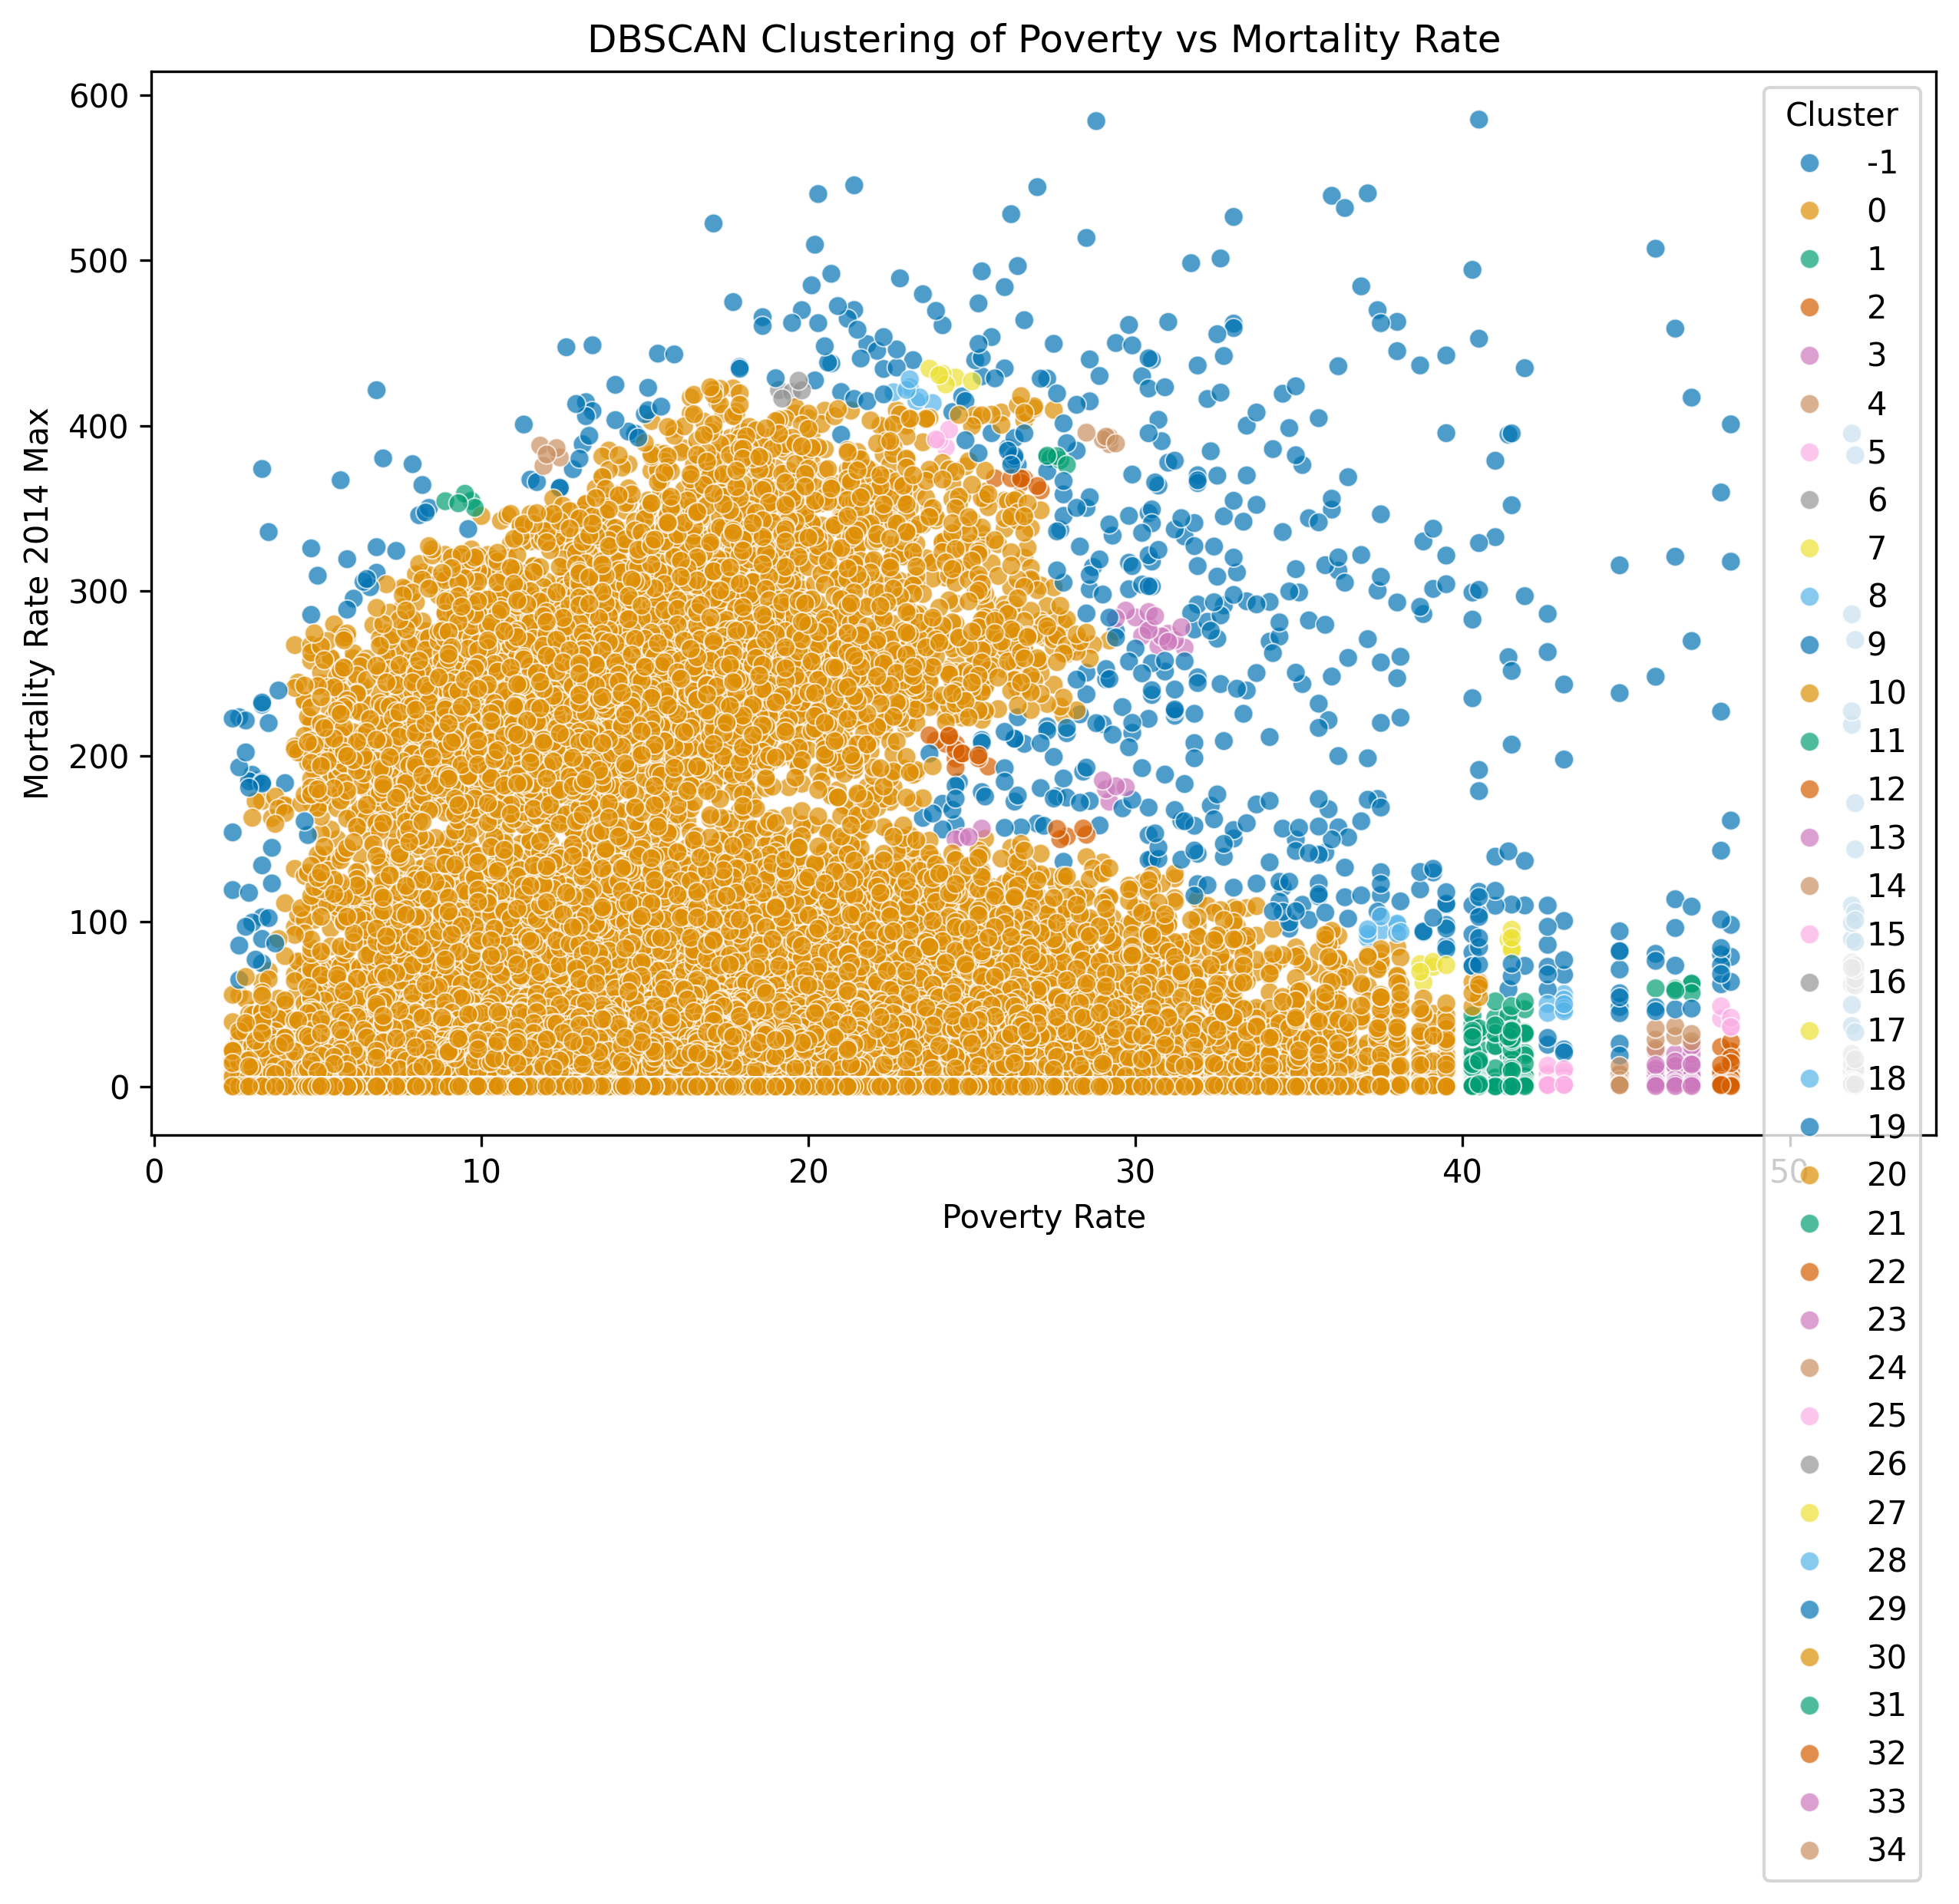

In [17]:
plt.figure(figsize=(10, 6), dpi=300)
sns.scatterplot(x=df['poverty'], y=df['mortality_rate_2014_max'], hue=df['Cluster'], palette='colorblind', alpha=0.7)
plt.title("DBSCAN Clustering of Poverty vs Mortality Rate")
plt.xlabel("Poverty Rate")
plt.ylabel("Mortality Rate 2014 Max")
plt.legend(title="Cluster")
plt.show()